In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import queue
from tqdm import tqdm
from typing import Callable,List,Tuple,Dict

cmap = plt.get_cmap('tab20') # type: ignore
State=Dict[any,int] # type: ignore

c:\Users\jw_be\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\jw_be\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Draw

In [2]:
def draw_graph(G:nx.Graph,state:State=None,label=False):
    if state is None:
        nx.draw(G, node_size = 80, alpha = 0.8)
        plt.show()
    else:
        map= [v for _,v in state.items()]
        u=np.unique(map)
        fixed_map=[np.where(u==i)[0][0] for i in map]
        node_cmap = [cmap(v) for v in fixed_map]
        
        pos = nx.spring_layout(G,seed=40)
        # add label too nodes
        if label:
            labels = {node:node for node in G.nodes()}
            nx.draw_networkx_labels(G, pos, labels, font_size=9)
            
        nx.draw(G, pos, node_size = 80, alpha = 0.8, node_color=node_cmap)
        plt.show()

# Utils

In [3]:
def state_partitions(state:State)->List[State]:
    comm_dict = {}
    for node,comm in state.items():
        if comm in comm_dict:
            comm_dict[comm].add(node)
        else:
            comm_dict[comm] = {node}
    return list(comm_dict.values())

In [4]:
def partitions_state(partitions):
    state = {}
    for i,comm in enumerate(partitions):
        for node in comm:
            state[node] = i
    return state

# Initialisation

In [5]:
def init_alea(G:nx.Graph,nb_communities=None)->State:
    if nb_communities is None: nb_communities = len(G.nodes())
    if (nb_communities>len(G.nodes())): raise ValueError("nb_communities must be less than the number of nodes")

    state = {node:np.random.randint(0,nb_communities) for node in G.nodes()}
    return state

In [6]:
def init_greedy(G:nx.Graph)->State:
    partitions= nx.algorithms.community.greedy_modularity_communities(G)
    state=partitions_state(partitions)
    return state

# Fonction de fitness

In [7]:
def modularity(G, state):
    if (len(G.nodes)<=1 or G.number_of_edges()==0): 
        return 0
    partitions = state_partitions(state)
    return nx.algorithms.community.modularity(G, partitions)

In [8]:
def coverage(G,state):
    """
    how many nodes in a graph are assigned to a community.
    """
    partitions = state_partitions(state)
    return nx.algorithms.community.quality.partition_quality(G,partitions)[0]

In [9]:
def performance(G,state):
    """
    measure of how well a community detection algorithm partitions the nodes in 
    a graph into communities that reflect the underlying structure of the graph.
    """
    partitions = state_partitions(state)
    return 1- nx.algorithms.community.quality.partition_quality(G,partitions)[1]

In [10]:
def cpm_modularity(G,state, gamma=0.5):
    """
    Calculates the modularity score of a graph using the Constant Potts Model (CPM).

    Parameters:
    - Q (nx.Graph): the graph to calculate the modularity score for.
    - gamma (float): the resolution parameter of the CPM.

    Returns:
    - modularity (float): the modularity score of the graph.
    """
    # Get the adjacency matrix of the graph
    A = nx.to_numpy_array(G)
    n = len(A)

    # Get the total weight of the graph
    m = np.sum(A) / 2

    # Calculate the degree of each node
    ki = np.sum(A, axis=1)

    # Calculate the modularity matrix
    B = A - gamma * np.outer(ki, ki) / (2 * m)

    # Calculate the modularity score
    
    partitions = state_partitions(state)
    ci = np.array(list(partitions))
    modularity = 0
    for c in ci:
        c=np.array(list(c))
        modularity += np.sum(B[np.ix_(c, c)])
    modularity /= (2 * m)

    return modularity

# Exploration du voisinage

In [11]:
def vertex_replacement(G:nx.Graph,state:State)->State:
    if(len(set(state.values()))==1):
        return state
    to_replace = np.random.choice(list(state.keys()))
    neighbors = list(G.neighbors(to_replace))
    # get neighbors that are not in the same community
    neighbors = [n for n in neighbors if state[n] != state[to_replace]]
    if len(neighbors)==0:
        return state
        
    replacement = np.random.choice(neighbors)
    new_state = state.copy()
    new_state[to_replace] = state[replacement]
    if modularity(G,new_state) > modularity(G,state):
        return new_state
        
    return state

In [12]:
def deplacement(G,state:State):
    if(len(set(state.values()))==1):
        return state
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random nodes in community
    community_nodes = [node for node in state.keys() if state[node] == community]
    number_of_nodes_to_move = np.random.randint(1,len(community_nodes)+1)
    nodes_to_move = np.random.choice(community_nodes, number_of_nodes_to_move, replace=False)
    # choose random community to move to
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in nodes_to_move:
        new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [13]:
def community_fusion(G,state:State):
    if(len(set(state.values()))==1):
        return state
    # choose random community
    community = np.random.choice(list(set(state.values())))
    # choose random community to fuse with
    new_community = np.random.choice(list(set(state.values()) - set([community])))
    new_state = state.copy()
    for node in new_state.keys():
        if new_state[node] == community:
            new_state[node] = new_community
    if modularity(G,new_state) > modularity(G,state):
        return new_state
    return state

In [14]:
def exhaustif_cross_mutation(G,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    node = np.random.choice(list(history[-1][1].keys()))
    # get nodes of the same community in every state
    neighbor_communities = []
    for _,state in history:
        comm=state[node]
        nodes_to_cross = [node for node in state.keys() if state[node] == comm]
        neighbor_communities.append(nodes_to_cross)

    states_cross=history.copy()
    for i,(_,state) in enumerate(history):
        for j,neighbor_community in enumerate(neighbor_communities):
            if(i==j):
                continue

            new_state = state.copy()
            for neighbor in neighbor_community:
                new_state[neighbor] = history[j][1][node]
            # check if new state already exists in history
            if(new_state in [state for _,state in states_cross]):
                continue
            mod=modularity(G,new_state)
            candidate = (mod, new_state)
            states_cross.append(candidate)
    
    states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [15]:
def cross_mutation(G:nx.Graph,history:List[Tuple[float,State]],N:int)->List[Tuple[float,State]]:
    if len(history) < 2:
        return history
    # choose random node
    states_cross=history.copy()

    node = np.random.choice(list(history[-1][1].keys()))
    # get two random states in history
    i,j = np.random.choice(range(len(history)), 2, replace=False)
    if i == j:
        return history
        
    state1=history[i][1]
    state2=history[j][1]
    neighbors_1 = [n for n in state1 if state1[n] == state1[node]]
    neighbors_2 = [n for n in state2 if state2[n] == state2[node]]

    new_C2=state2.copy()
    for n in neighbors_1:
        new_C2[n]=state1[node]

    if (not new_C2 in [state for _,state in states_cross]):
        mod=modularity(G,new_C2)
        candidate = (mod, new_C2)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    new_C1=state1.copy()
    for n in neighbors_2:
        new_C1[n]=state2[node]

    if (not new_C1 in [state for _,state in states_cross]):
        mod=modularity(G,new_C1)
        candidate = (mod, new_C1)
        states_cross.append(candidate)
        states_cross=heapq.nlargest(N, states_cross,key=lambda x: x[0])

    return states_cross

In [16]:
voisinage1=[vertex_replacement,deplacement,community_fusion]
def get_successors1(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=voisinage1[np.random.randint(0,3)](G,state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=cross_mutation(G,successors,N)
    return successors

In [17]:
voisinage2=[vertex_replacement,deplacement]
def get_successors2(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=voisinage2[np.random.randint(0,2)](G,state)
        new_state=community_fusion(G,new_state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=cross_mutation(G,successors,N)
    return successors

In [18]:
def get_successors3(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=vertex_replacement(G,state)
        new_state=community_fusion(G,new_state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=cross_mutation(G,successors,N)
    return successors

In [19]:
def get_successors4(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    for _ in range(N):
        new_state=deplacement(G,state)
        new_state=community_fusion(G,new_state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=cross_mutation(G,successors,N)
    return successors

In [20]:
def get_successors5(G:nx.Graph,state:State,N:int)->List[Tuple[float,State]]:
    successors:List[Tuple[float,State]] = []
    sqrt=int(Math.sqrt(N))
    for _ in range(sqrt+1):
        new_state=voisinage2[np.random.randint(0,2)](G,state)
        new_state=community_fusion(G,new_state)
        mod=modularity(G,new_state)
        successor=(mod,new_state)
        successors.append(successor)
        
    successors=heapq.nlargest(N, successors,key=lambda x: x[0])
    successors=exhaustif_cross_mutation(G,successors,N)
    return successors

In [21]:
def var(beam):
    mod = [ sol[0] for sol in beam]
    mean = sum(mod)/len(beam)
    variance = sum((x - mean) ** 2 for x in mod) / len(mod)
    return variance


In [22]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi

def similarity(beam):
    nmi_values = []
    n_partitions = len(beam)
    states = [ sol[1] for sol in beam]
    partitions = [list(state.values()) for state in states]

    for i in range(n_partitions):
        for j in range(i + 1, n_partitions):
            nmi_values.append(nmi(partitions[i], partitions[j]))

    return sum(nmi_values) / len(nmi_values)


In [42]:
def get_graph(data):
    G = nx.Graph()
    if data.x is not None:
        G.add_nodes_from(range(data.x.shape[0]))
    elif data.num_nodes is not None:
        G.add_nodes_from(range(data.num_nodes))

    G.add_edges_from(data.edge_index.t().tolist())
    return G

In [23]:
import pickle
scaler = pickle.load(open('scaler.pkl', 'rb'))
model = pickle.load(open('linearRegression_model.pkl','rb'))

In [24]:
def predict_beam(X):
    X = scaler.transform([X])
    [result] = model.predict(X)
    # round to integer
    result = int(round(result))
    return result

In [26]:
class BeamSearch_Dynamic:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int
    history:queue.Queue
    

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], init_beam_width:int=10,nb_successors:int=10,hist_size=False):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.

        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = init_beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.modularity=evaluate(G,start_state)
        self.beam = [(self.modularity, start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors
        self.hist_size=hist_size
        if hist_size:
            self.history=queue.Queue()
            self.history.put(self.modularity)

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.
            if self.hist_size:
                self.history.put(self.beam[0][0])
                if(self.history.qsize()>self.hist_size):
                    self.history.get()
                # if all history are the same
                if(self.history.qsize()>=self.hist_size and len(set(list(self.history.queue)))==1):
                    break
            
            variance=var(self.beam)
            sim=similarity(self.beam)
            delta_mod=self.beam[0][0]-self.modularity
            nodes_num=self.G.number_of_nodes()
            nb_communities=len(set(list(self.best_state.values())))
            data=[variance,sim,delta_mod,nodes_num,nb_communities,self.beam[0][0]]
            self.beam_width=predict_beam(data)
            # TODO: fill beam with cross mutation

            if self.modularity < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
                self.modularity = self.beam[0][0]
        
        return self.best_state


In [58]:
from torch_geometric.datasets import TUDataset
data=TUDataset(root='data/TUDataset', name='REDDIT-MULTI-5K')[0]
G=get_graph(data)
start_state = init_greedy(G)

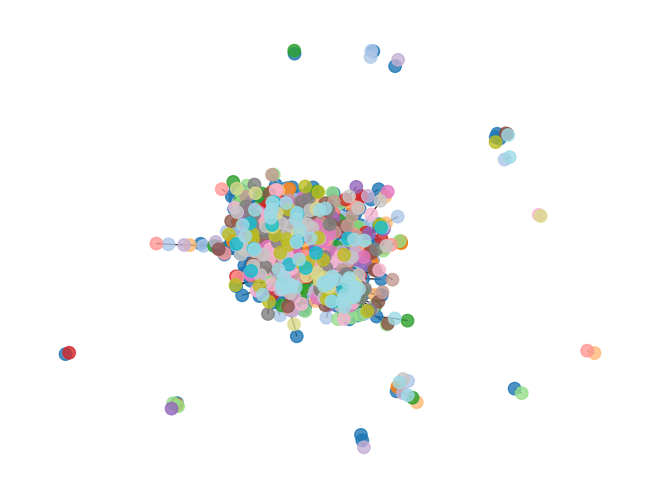

In [59]:
draw_graph(G,start_state)

In [60]:
beam_search=BeamSearch_Dynamic(G,start_state,get_successors1,modularity,init_beam_width=10,nb_successors=10,hist_size=10)

In [61]:
result=beam_search.search(300)

 17%|█▋        | 51/300 [10:31<51:21, 12.38s/it]  


In [62]:
print(result)
print("old modularity",modularity(G,start_state))
print("new modularity",modularity(G,result))

{1: 0, 5: 0, 11: 0, 12: 0, 13: 0, 15: 0, 17: 0, 18: 0, 24: 0, 30: 0, 37: 0, 39: 0, 43: 0, 48: 0, 49: 0, 50: 0, 52: 0, 58: 0, 61: 0, 62: 0, 65: 0, 67: 0, 68: 0, 70: 0, 71: 0, 72: 0, 73: 0, 77: 0, 79: 0, 92: 0, 95: 0, 98: 0, 99: 0, 100: 0, 104: 0, 105: 0, 106: 0, 107: 0, 111: 0, 116: 0, 122: 0, 127: 0, 128: 0, 129: 0, 132: 0, 134: 0, 135: 0, 136: 0, 138: 0, 143: 0, 146: 0, 149: 0, 150: 0, 151: 0, 153: 0, 154: 0, 157: 0, 158: 0, 161: 0, 165: 0, 166: 0, 170: 0, 172: 0, 174: 0, 186: 0, 187: 0, 190: 0, 191: 0, 195: 0, 196: 0, 197: 0, 199: 0, 203: 0, 204: 0, 205: 0, 206: 0, 207: 0, 210: 0, 213: 0, 214: 0, 216: 0, 219: 0, 224: 0, 225: 0, 226: 0, 227: 0, 228: 0, 229: 0, 233: 0, 237: 0, 241: 0, 245: 0, 246: 0, 247: 0, 248: 0, 253: 0, 254: 0, 255: 0, 256: 0, 257: 0, 260: 0, 261: 0, 263: 0, 267: 0, 268: 0, 269: 0, 275: 0, 284: 0, 293: 0, 296: 0, 298: 0, 308: 0, 309: 0, 310: 0, 312: 0, 314: 0, 315: 0, 318: 0, 323: 0, 326: 0, 328: 0, 333: 0, 349: 0, 352: 0, 354: 0, 355: 0, 358: 0, 359: 0, 361: 0, 36

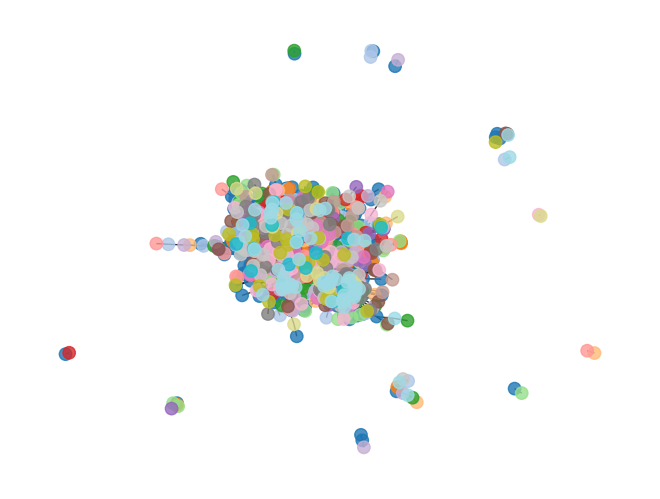

In [63]:
draw_graph(G,result)

In [29]:
class BeamSearch:
    
    G:nx.Graph
    beam:List[Tuple[float,State]]
    best_state:State
    get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]]
    evaluate:Callable[[nx.Graph,State],float]
    beam_width:int
    nb_successors:int
    history:queue.Queue
    

    def __init__(self, G:nx.Graph,start_state:State, get_successors:Callable[[nx.Graph,State,int],List[Tuple[float,State]]], evaluate:Callable[[nx.Graph,State],float], beam_width:int=10,nb_successors:int=10,hist_size=False):
        """
        Effectue une recherche par faisceau (beam search).

        Args:
            start_state (object): L'état initial de la recherche.
            beam_width (int): La taille du faisceau (nombre de candidats à considérer).
            max_steps (int): Le nombre maximum d'étapes à effectuer.
            get_successors (function): la fonction de voisinage qui retourne les successeurs d'un états (voisins).
            evaluate (function): Une fonction qui prend un état en argument et retourne une valeur d'évaluation.
        Returns:
            object: Le meilleur état trouvé par la beam search.
        """
        self.G = G
        self.beam_width = beam_width
        self.get_successors = get_successors
        self.evaluate = evaluate
        self.modularity=evaluate(G,start_state)
        self.beam = [(self.modularity, start_state)]
        self.best_state = start_state
        self.nb_successors=nb_successors
        self.hist_size=hist_size
        if hist_size:
            self.history=queue.Queue()
            self.history.put(self.modularity)

    def search(self,max_steps:int):
        for _ in tqdm(range(max_steps)):
            candidates:List[Tuple[float,State]] = []  # Liste pour stocker les nouveaux candidats pour chaque étape
            candidates.extend(self.beam)
            for _, state in self.beam:
                successors = self.get_successors(self.G,state,self.nb_successors)
                # push successors in candidates
                candidates.extend(successors)
            self.beam = heapq.nlargest(self.beam_width, candidates,key=lambda x: x[0])  # Sélectionne les meilleurs candidats, la beam c'est l'ensemble des noeuds accepté dans un niveau.
            if self.hist_size:
                self.history.put(self.beam[0][0])
                if(self.history.qsize()>self.hist_size):
                    self.history.get()
                # if all history are the same
                if(self.history.qsize()>=self.hist_size and len(set(list(self.history.queue)))==1):
                    break

            if self.modularity < self.beam[0][0]:
                self.best_state = self.beam[0][1]  # Meilleur état trouvé
                self.modularity = self.beam[0][0]
        
        return self.best_state
